<a href="https://colab.research.google.com/github/alcoleasnoelia/Proyecto1-IA-DigitalHouse-Grupo4/blob/master/Notebook%20l%20-%20An%C3%A1lisis_Inicial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notebook 1

1.  Objetivo
2.  Importación de Librerias 
3.  Análisis Preliminar de Dataset y Visualización de Datos
    *   Exploración
    *   Limpieza Inicial de datos
    *   Sentimental Analisis

Notebook 2

4.  Feature Extraction
    *   Count Vectorizer
    *   TF-IDF Vectorizer
5.  Modelado Inicial - Árboles de Decisión
    *   Clasificadores
    *   Cross Validation / GRIDSEARCH / RANDOMSEARCH ETC
    *   Modelos de Ensamble

Notebook 3
    
6.  Modelado Avanzado Neural Networks (LSTMs)
    *   Red Secuencial Inicial
    *   Red Secuencial con regularizaciómn 
    *   Modelado de Red con Cross Validation
    *   Análisis final de performance
7.  Conclusiones





# **1.   Objetivo**



Construcción de un modelo de clasificación binaria de fake news  aplicando técnicas de procesamiento y clasificación de texto. Benchmark entre modelos de clasificación utilizando modelos de Machine Learning Tradicional versus Redes Neuronales de capas densas con diferentes parametrizaciones aplicadas.

# **2.   Importación de Librerias**



In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.stem.snowball import SnowballStemmer
import pickle

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sanapolsky\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sanapolsky\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
def correr_stemming(text):
    # Stemming
    text = text.split()
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in text]
    text = " ".join(stemmed_words)
    return(text)

# **3.   Análisis Preliminar de Dataset y Visualización de Datos**


Cargamos los datasets a partir de los csv:

In [0]:
true = pd.read_csv("True.csv")
false = pd.read_csv("Fake.csv")

In [0]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [0]:
false.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [0]:
true.head(5).text.apply(correr_stemming)

0    washington (reuters) - the head of a conserv r...
1    washington (reuters) - transgend peopl will be...
2    washington (reuters) - the special counsel inv...
3    washington (reuters) - trump campaign advis ge...
4    seattle/washington (reuters) - presid donald t...
Name: text, dtype: object

Ploteamos un Worcloud de las palabras basadas en su frecuencia, excluyendo las palabras incluidas en el diccionario de stopwords en inglés.

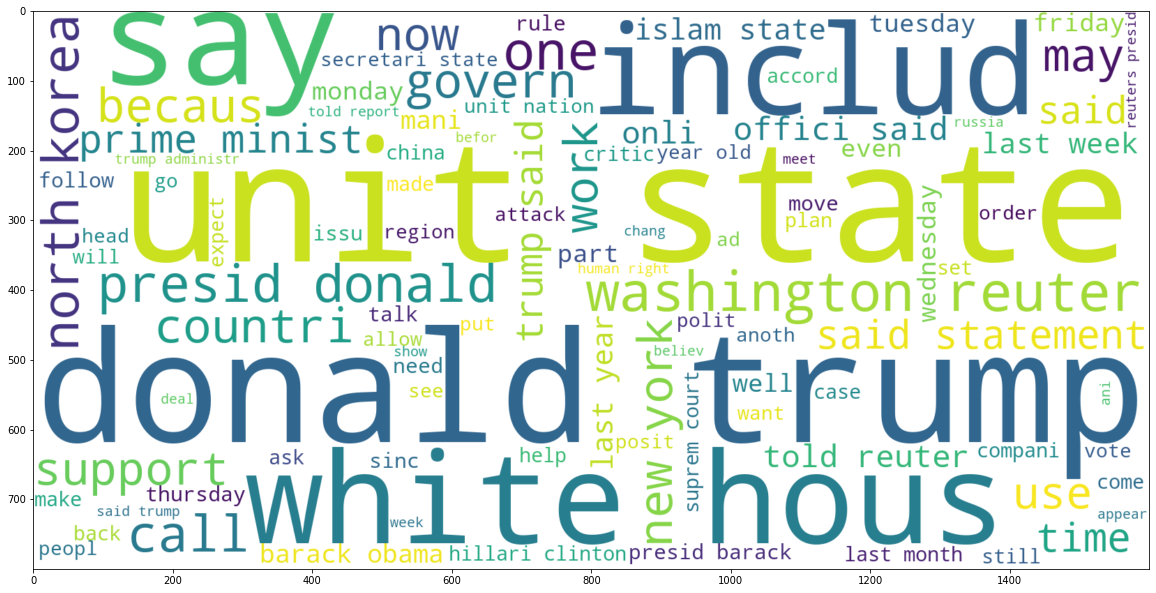

In [0]:
#WORDCLOUD DE NOTICIAS VERDADERAS

true['text_st'] = true.text.apply(correr_stemming)

plt.figure(figsize = (20,20))
word_true = WordCloud(max_words = 100 , width = 1600 ,background_color="white", height = 800,stopwords = STOPWORDS).generate(" ".join(true.text_st))
plt.imshow(word_true, interpolation = 'bilinear')


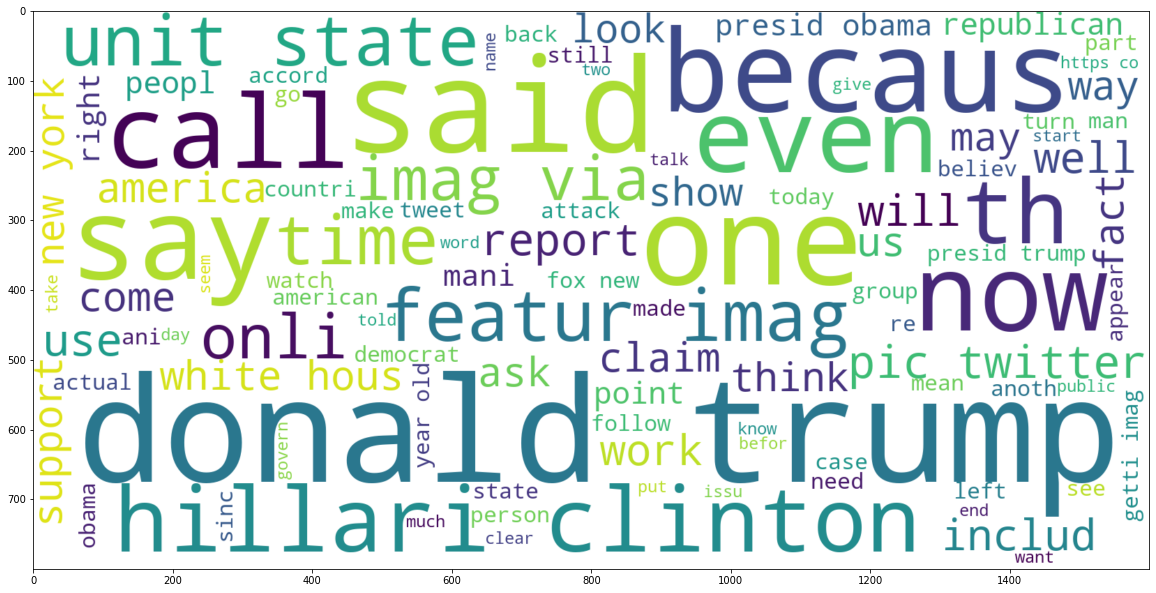

In [0]:
#WORDCLOUD DE NOTICIAS FALSAS

false['text_st'] = false.text.apply(correr_stemming)

plt.figure(figsize = (20,20))
word_false = WordCloud(max_words = 100 , width = 1600 , background_color="white", height = 800,stopwords = STOPWORDS).generate(" ".join(false.text_st))
plt.imshow(word_false, interpolation = 'bilinear')

Agregamos los valores numericos, como un booleano (este último a efectos del gráfico de polarity y subjectivity que se muestra más adelante).

In [0]:
true['fakenews_'] = 0
false['fakenews_'] = 1

Unificamos el dataset:

In [0]:
news = pd.concat([true,false]) 

Validamos mediante value_counts que las clases se encuentran balanceadas, ploteando luego los resultados:

In [0]:
news["fakenews_"].value_counts()

1    23481
0    21417
Name: fakenews_, dtype: int64

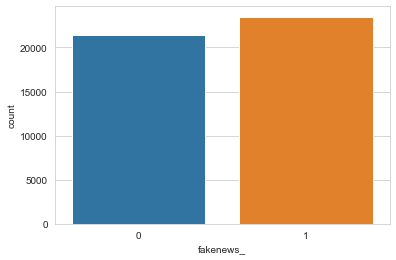

In [0]:
target=news["fakenews_"]
sns.set_style("whitegrid")
sns.countplot(target)

Validaciones de integridad:
- Valores nulos
- Count de valores
- Tipo de datos

In [0]:
news.isna().sum()

title        0
text         0
subject      0
date         0
text_st      0
fakenews_    0
dtype: int64

In [0]:
news.title.count()

44898

In [0]:
news.dtypes

title        object
text         object
subject      object
date         object
text_st      object
fakenews_     int64
dtype: object

Agrupamos los valores según subject para plotear el count de los mismos:

In [0]:
a = pd.DataFrame(news['subject'].value_counts(sort=True)[0:8]).reset_index()
datos_por_tema = a.copy()
datos_por_tema['Seccion'] = datos_por_tema['index']
datos_por_tema['Cdad'] = datos_por_tema['subject']
datos_por_tema.drop(columns=['index','subject'],inplace=True)


datos_por_tema

,Seccion,Cdad
0,politicsNews,11272
1,worldnews,10145
2,News,9050
3,politics,6841
4,left-news,4459
5,Government News,1570
6,US_News,783
7,Middle-east,778


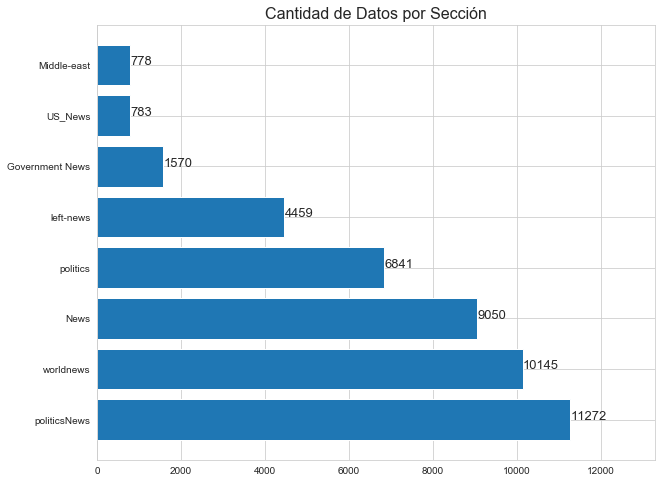

In [0]:
plt.figure(figsize=(10,8))
plt.barh(y=datos_por_tema['Seccion'],width=datos_por_tema['Cdad'])
for i,v in enumerate(datos_por_tema['Seccion']):
    plt.text(datos_por_tema['Cdad'][i],i,datos_por_tema['Cdad'][i],fontsize=13)
plt.xlim([0,13300])
plt.title('Cantidad de Datos por Sección',fontsize=16)
plt.savefig('Cant. de Datos por Sección.png')


LIMPIEZA INICIAL DE DATOS

In [0]:
import re
import string

def clean_text(text):
    """
    :param data: str
    :return:

    clean_text function filters out relevent string blocks on the basis of regular expression.
    """

    text = text.lower()
    
    # Remover lo que está antes de reuters
    if text.lower().find('(reuters) -') > 0: text = text[text.lower().find('(reuters) -')+12:]
    
    # Remove puncuation
    text = re.sub('['+string.punctuation+']', '', text)
    text = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", text)

    # Convert words to lower case and split them

    text = text.split()
    
    # Remove stop words

    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops] #and len(w) >= 3
    text = " ".join(text)

    # Clean the text

    # \w matches letters and underscores, \W as opposite match all but letters and undescores,
    # so [^\W_] will match letters only (thanks to the negation ^).
    text = re.sub(r'[\W_]', " ", text)

    
    
    # Space substitution
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ", text)
    text = re.sub(r"\+", " ", text)
    text = re.sub(r"\-", " ", text)
    text = re.sub(r"\=", " ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " ", text)

    text = re.sub(r"\0s", "0", text)
    text = re.sub(r"e - mail", "email", text)

    text = re.sub(r'[0-9]+', ' ', text)
    text = re.sub(r'[\n\t]', ' ', text)
    text = re.sub("„", " ", text)

    return text



news['title_clean'] = news.title.apply(clean_text)

news['text_clean'] = news.text.apply(clean_text)


display(news.head())

,title,text,subject,date,text_st,fakenews_,title_clean,text_clean
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",washington (reuters) - the head of a conserv r...,0,us budget fight looms republicans flip fiscal ...,head conservative republican faction us congre...
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",washington (reuters) - transgend peopl will be...,0,us military accept transgender recruits monday...,transgender people allowed first time enlist u...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",washington (reuters) - the special counsel inv...,0,senior us republican senator let mr mueller job,special counsel investigation links russia pre...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",washington (reuters) - trump campaign advis ge...,0,fbi russia probe helped australian diplomat ti...,trump campaign adviser george papadopoulos tol...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",seattle/washington (reuters) - presid donald t...,0,trump wants postal service charge much amazon ...,president donald trump called us postal servic...


In [0]:
news['title_clean'] = news.title.apply(clean_text)
news['text_clean'] = news.text.apply(clean_text)

In [0]:
display(news.head())

,title,text,subject,date,text_st,fakenews_,title_clean,text_clean
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",washington (reuters) - the head of a conserv r...,0,us budget fight looms republicans flip fiscal ...,head conservative republican faction us congre...
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",washington (reuters) - transgend peopl will be...,0,us military accept transgender recruits monday...,transgender people allowed first time enlist u...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",washington (reuters) - the special counsel inv...,0,senior us republican senator let mr mueller job,special counsel investigation links russia pre...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",washington (reuters) - trump campaign advis ge...,0,fbi russia probe helped australian diplomat ti...,trump campaign adviser george papadopoulos tol...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",seattle/washington (reuters) - presid donald t...,0,trump wants postal service charge much amazon ...,president donald trump called us postal servic...


In [0]:
news.columns

Index(['title', 'text', 'subject', 'date', 'text_st', 'fakenews_',
       'title_clean', 'text_clean'],
      dtype='object')

Realizamos una comparativa entre los corpus originales y aquellos sobre los que se aplicó cleansing:

In [0]:
x = news[news.fakenews_==1].title_clean.sample(1).index.to_list()
print('Fake')
display(news.loc[x].title.values[0])
display(news.loc[x].title_clean.values[0])
print('Real')
x = news[news.fakenews_==0].title_clean.sample(1).index.to_list()
display(news.loc[x].title.values[0])
display(news.loc[x].title_clean.values[0])

Fake


"U.S. warns North Korean leadership will be 'utterly destroyed' in case of war"

'us warns north korean leadership utterly destroyed case war'

Real


'Trump criticized in Britain and U.S. for sharing anti-Muslim videos'

'trump criticized britain us sharing antimuslim videos'

Visualizamos como quedaron los corpus de los textos con limpieza:

In [0]:
print('Noticia Verdadera')
display(news[news.fakenews_==0].text_clean.sample(1).values)

Noticia Verdadera


array(['chanting flailing mourning imam hussein hundreds thousands shi ite muslims around world gathered iraqi city kerbala friday one sacred rituals religious calendar arbain marks culmination  day mourning period imam hussein grandson prophet mohammed killed  th century battle kerbala shi ites believe remains entombed exhausted pilgrims including women carrying children marched long distances reach shrines many arriving air iran pakistan bahrain landed baghdad several days earlier kerbala   km   miles south capital cloaked black robes worn pilgrims bedecked sea flags saddam hussein sunni banned shi ite gatherings religious events decades pilgrims gathered sacred shi ite cities including kerbala najaf religious duties since usled invasion toppled   gatherings marred suicide bombings carried sunni militants notably al qaeda islamic state regard iraq majority shi ites infidels groups largely defeated usbacked iraqi security forces shi ite pilgrims may peace mind year arbain though secur

In [0]:
print('Noticia Falsa')
display(news[news.fakenews_==1].text_clean.sample(1).values)

Noticia Falsa


array(['abortion became legal procedure   according supreme court woman right privacy   years later republican judge put new spin abortion debate ruled fine doctor discriminate woman ever abortion discriminate men man born female body partsthe affordable care act obamacare forbids discrimination basis sex gender identity also forbids discrimination based whether woman abortion words federal government applied fairly broad definition sex discrimination shouldus justice reed connor different vision though ruled sex discrimination one meaning discrimination woman woman man man slate points though determine man womanbut connor recognizes one kind sex discrimination hostility man woman man woman belief directly contradicts supreme court authority also make much sense since raises key question decides whether individual man woman discrimination intersex person sex discrimination person ambiguous genitalia identifies male still connor got away blinkered understanding sex blocking federal guid

Análisis de Sentimiento


In [0]:
from textblob import TextBlob

def detect_polarity(text): return TextBlob(text).sentiment.polarity
def detect_subjectivity(text): return TextBlob(text).sentiment.subjectivity
    
news['text_polarity'] = news.text.apply(detect_polarity)
news['text_subjectivity'] = news.text.apply(detect_subjectivity)

display(news.groupby('fakenews_').mean())

news['title_polarity'] = news.title.apply(detect_polarity)
news['title_subjectivity'] = news.title.apply(detect_subjectivity)

display(news.groupby('fakenews_').mean())

news['text_clean_polarity'] = news.text_clean.apply(detect_polarity)
news['text_clean_subjectivity'] = news.text_clean.apply(detect_subjectivity)

display(news.groupby('fakenews_').mean())

news['title_clean_polarity'] = news.title_clean.apply(detect_polarity)
news['title_clean_subjectivity'] = news.title_clean.apply(detect_subjectivity)

display(news.groupby('fakenews_').mean())


print(news.fakenews_.value_counts(normalize=True))
news.groupby('fakenews_').mean()

,text_polarity,text_subjectivity
fakenews_,,
0,0.053533,0.361708
1,0.059474,0.433674


,text_polarity,text_subjectivity,title_polarity,title_subjectivity
fakenews_,,,,
0,0.053533,0.361708,0.024714,0.174123
1,0.059474,0.433674,0.003224,0.377440


,text_polarity,text_subjectivity,title_polarity,title_subjectivity,text_clean_polarity,text_clean_subjectivity
fakenews_,,,,,,
0,0.053533,0.361708,0.024714,0.174123,0.043071,0.346382
1,0.059474,0.433674,0.003224,0.377440,0.046756,0.425666


,text_polarity,text_subjectivity,title_polarity,title_subjectivity,text_clean_polarity,text_clean_subjectivity,title_clean_polarity,title_clean_subjectivity
fakenews_,,,,,,,,
0,0.053533,0.361708,0.024714,0.174123,0.043071,0.346382,0.018653,0.162955
1,0.059474,0.433674,0.003224,0.377440,0.046756,0.425666,-0.003662,0.365974


1    0.522985
0    0.477015
Name: fakenews_, dtype: float64


,text_polarity,text_subjectivity,title_polarity,title_subjectivity,text_clean_polarity,text_clean_subjectivity,title_clean_polarity,title_clean_subjectivity
fakenews_,,,,,,,,
0,0.053533,0.361708,0.024714,0.174123,0.043071,0.346382,0.018653,0.162955
1,0.059474,0.433674,0.003224,0.377440,0.046756,0.425666,-0.003662,0.365974


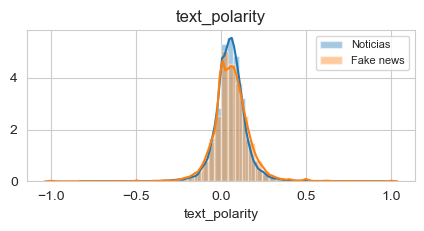

In [0]:
var = 'text_polarity'

fig, ax = plt.subplots(figsize=(5, 2), dpi=100)  
ax = sns.distplot(news[news.fakenews_==0][var], label="Noticias")
ax = sns.distplot(news[news.fakenews_==1][var], label="Fake news")
ax.set_title(var, fontsize=12 )
plt.legend(prop={"size":8})

#Guardamos el gráfico obtenido
plt.savefig('Text Polarity')



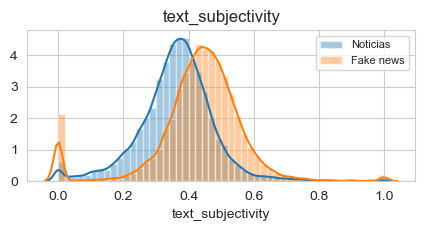

In [0]:
var = 'text_subjectivity'
fig, ax = plt.subplots(figsize=(5, 2), dpi=100)  
ax = sns.distplot(news[news.fakenews_==0][var], label="Noticias")
ax = sns.distplot(news[news.fakenews_==1][var], label="Fake news")
ax.set_title(var, fontsize=12 )
plt.legend(prop={"size":8})

#Guardamos el gráfico obtenido
plt.savefig('Text Subjectivity')

Conservamos la columna del título y texto para la obtención de las variables


In [0]:
news.columns

Index(['title', 'text', 'subject', 'date', 'text_st', 'fakenews_',
       'title_clean', 'text_clean', 'text_polarity', 'text_subjectivity',
       'title_polarity', 'title_subjectivity', 'text_clean_polarity',
       'text_clean_subjectivity', 'title_clean_polarity',
       'title_clean_subjectivity'],
      dtype='object')

In [0]:
# news['title'] =  news['title_clean'] 
# news['text'] =  news['text_clean'] 

# del news['subject']
# del news['date']
# del news['text_clean']
# del news['title_clean']
# del news['text_polarity']
# del news['text_subjectivity']
# del news['title_polarity']
# del news['title_subjectivity']
# del news['text_clean_polarity']
# del news['text_clean_subjectivity']
# del news['title_clean_polarity']
# del news['title_clean_subjectivity']

In [0]:
news.head(5)

,title,text,subject,date,text_st,fakenews_,title_clean,text_clean,text_polarity,text_subjectivity,title_polarity,title_subjectivity,text_clean_polarity,text_clean_subjectivity,title_clean_polarity,title_clean_subjectivity
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",washington (reuters) - the head of a conserv r...,0,us budget fight looms republicans flip fiscal ...,head conservative republican faction us congre...,0.037083,0.410250,0.00,0.0,0.036979,0.403438,0.0,0.00
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",washington (reuters) - transgend peopl will be...,0,us military accept transgender recruits monday...,transgender people allowed first time enlist u...,0.055880,0.298557,-0.10,0.1,0.113095,0.296168,-0.1,0.10
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",washington (reuters) - the special counsel inv...,0,senior us republican senator let mr mueller job,special counsel investigation links russia pre...,0.115930,0.316798,0.00,0.0,0.129766,0.311252,0.0,0.00
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",washington (reuters) - trump campaign advis ge...,0,fbi russia probe helped australian diplomat ti...,trump campaign adviser george papadopoulos tol...,0.035968,0.306569,0.00,0.0,0.030305,0.276323,0.0,0.00
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",seattle/washington (reuters) - presid donald t...,0,trump wants postal service charge much amazon ...,president donald trump called us postal servic...,0.030093,0.399891,0.35,0.3,0.042130,0.379259,0.2,0.15


Guardamos el texto en un pickle para trabajarlo en la notebook del modelo

In [0]:
pickle.dump(news,open('news_.p', "wb"))